# Surgery pipeline with TRVAE - comparison between zero-, one-shot and full query training

In [1]:
import scib

In [2]:
import os
import timeit
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
Global seed set to 0
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training length

In [5]:
condition_key = 'batch'
cell_type_key = 'final_annotation'
target_conditions = ['10X']

trvae_epochs = 500
alpha_epoch = 200 
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [6]:
url = 'https://figshare.com/ndownloader/files/25717328'
output = 'Immune_ALL_human.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://figshare.com/ndownloader/files/25717328
To: /home/icb/aleksandra.topalova/scarches/notebooks/Immune_ALL_human.h5ad
100%|██████████| 2.06G/2.06G [00:36<00:00, 55.9MB/s]


'Immune_ALL_human.h5ad'

In [7]:
adata = sc.read('Immune_ALL_human.h5ad')

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/batch' was written without encoding metadata.
  categories = read_elem(categories_dset)
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/batch' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:584: 

In [8]:
adata.X = adata.layers["counts"].copy()

In [9]:
adata = adata[~adata.obs[condition_key].isin(['Villani'])]
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
source_conditions = source_adata.obs[condition_key].unique().tolist()

In [10]:
target_adata.obs['ref_or_query'] = 'query'
source_adata.obs['ref_or_query'] = 'ref'

In [11]:
source_adata

AnnData object with n_obs × n_vars = 21757 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query'
    layers: 'counts'

In [12]:
target_adata

AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query'
    layers: 'counts'

In [13]:
source_adata.raw = source_adata
sc.pp.normalize_total(source_adata)
sc.pp.log1p(source_adata)

In [14]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [15]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

In [16]:
source_adata

AnnData object with n_obs × n_vars = 21757 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

### Create TRVAE model and train it on reference dataset

Create the trVAE model instance with NB loss as default. Insert "recon_loss='mse'," or "recon_loss='zinb'," to change the reconstruction loss.

In [17]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 8
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 8
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [18]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=alpha_epoch,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

 |███████-------------| 36.8%  - val_loss: 656.3919318704 - val_recon_loss: 611.6929357192 - val_kl_loss: 15.8812093174 - val_mmd_loss: 30.1676927454
ADJUSTED LR
 |████████------------| 40.6%  - val_loss: 655.3183414235 - val_recon_loss: 610.4293607824 - val_kl_loss: 15.4884569505 - val_mmd_loss: 29.4005130319
ADJUSTED LR
 |████████------------| 44.0%  - val_loss: 655.8625236960 - val_recon_loss: 610.3438002642 - val_kl_loss: 15.4323505514 - val_mmd_loss: 30.0863755170
ADJUSTED LR
 |█████████-----------| 47.2%  - val_loss: 655.5960262523 - val_recon_loss: 610.0328010110 - val_kl_loss: 15.4356921140 - val_mmd_loss: 30.1275336322
ADJUSTED LR
 |█████████-----------| 48.6%  - val_loss: 656.8480799058 - val_recon_loss: 610.5041755227 - val_kl_loss: 15.4362057518 - val_mmd_loss: 30.9076976776
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of n

### Create anndata file of latent representation and compute UMAP

In [19]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


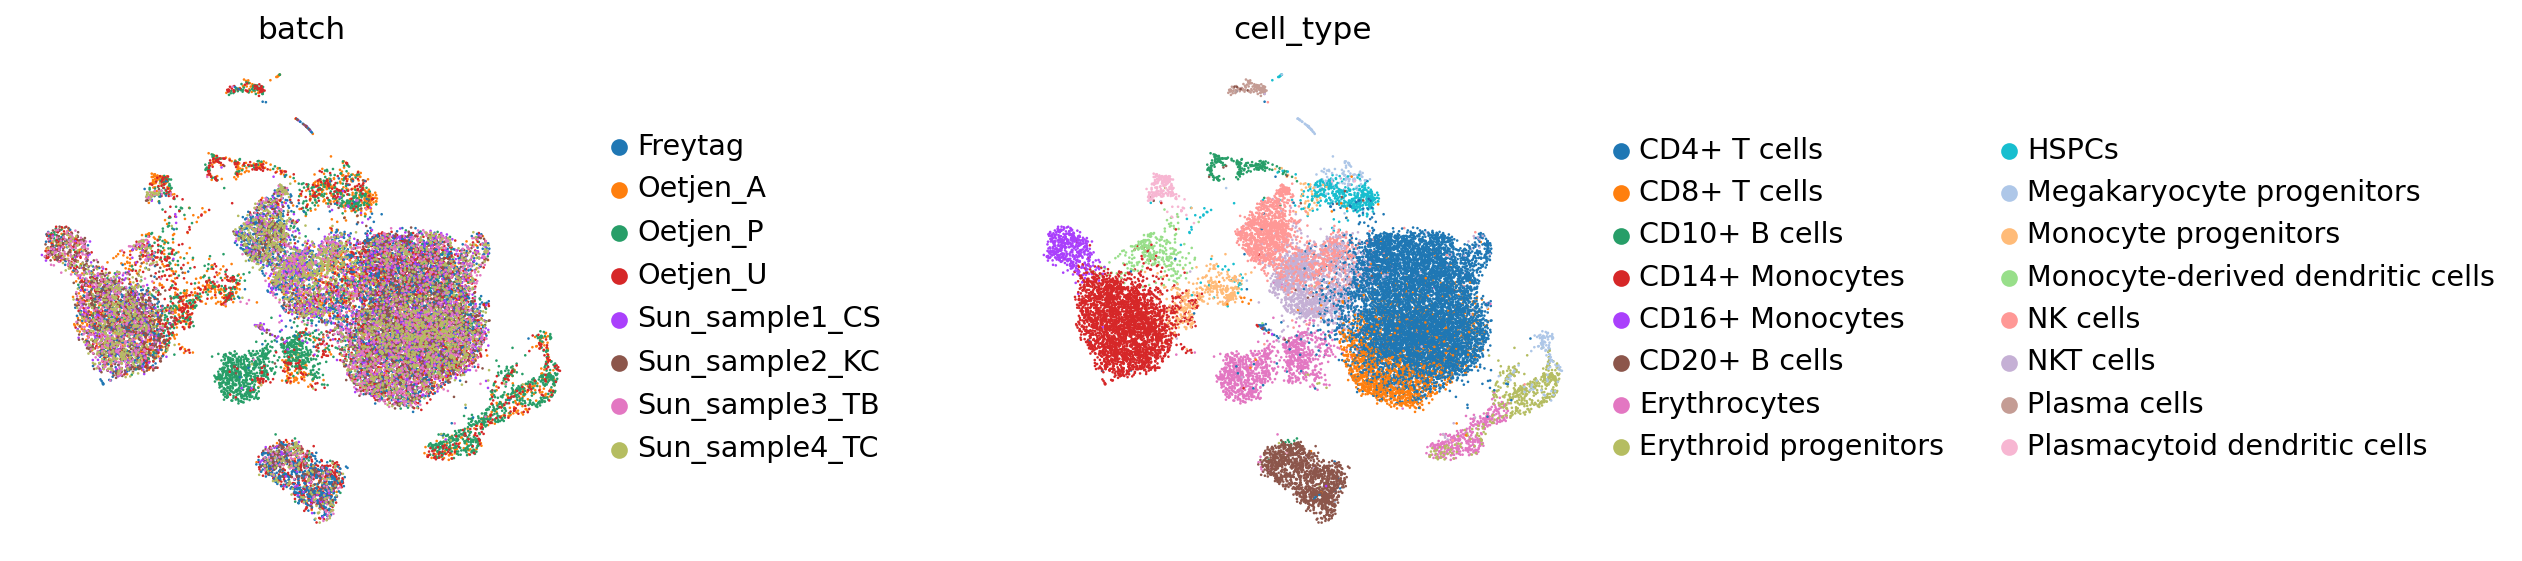

In [20]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use

In [21]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

In [22]:
target_adata = target_adata[:, source_adata.var_names]
target_adata

View of AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query'
    layers: 'counts'

### Perform surgery on reference model and train on query dataset using one-shot mapping

In [23]:
time_one_array = []

for epochs in reversed(range(1,11)):
    start_time_1 = timeit.default_timer()

    query_model_one_1 = trvae.one_shot_surgery(target_adata, ref_path, copy=False, pretrain = epochs)

    time_one = timeit.default_timer() - start_time_1
    print(f'Executed in {time_one} seconds') 
    
    if epochs == 10:
        query_model_one = query_model_one_1
        val_loss_1 = query_model_one.trainer.logs['val_loss']
    time_one_array.append(time_one)

AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query', '_original_batch'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 8
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 8
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

Device cpu
Processing original category: 10X n_obs: 10727
  processing Oetjen_A
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing Sun_sample1_CS
  processing Sun_sample2_KC
  processing Sun_sample3_TB
  processing Sun_sample4_TC

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10


### Perform surgery on reference model and train on query dataset using zero-shot mapping

In [24]:
start_time_0 = timeit.default_timer()

query_model_zero = trvae.one_shot_surgery(target_adata, ref_path, copy=False, pretrain = 0)

time_zero = timeit.default_timer() - start_time_0
print(f'Executed in {time_zero} seconds')

AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query', '_original_batch'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 8
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 8
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

Device cpu
Processing original category: 10X n_obs: 10727
  processing Oetjen_A
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing Sun_sample1_CS
  processing Sun_sample2_KC
  processing Sun_sample3_TB
  processing Sun_sample4_TC

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10


### Perform surgery on reference model and train on query dataset using full query training

In [25]:
query_model_full = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=ref_path)

AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query', '_original_batch'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [26]:
start_time_f = timeit.default_timer()

query_model_full.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=alpha_epoch,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

time_full = timeit.default_timer() - start_time_f
print(f'Executed in {time_full} seconds') 

 |███-----------------| 15.4%  - val_loss: 1088.2367485894 - val_recon_loss: 1080.2122667101 - val_kl_loss: 21.1170853509 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |███-----------------| 16.8%  - val_loss: 1097.1614718967 - val_recon_loss: 1088.4056667752 - val_kl_loss: 21.0983181000 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 62
Executed in 50.45121137984097 seconds


#### Time Benchmarking results

In [27]:
time_zero

10.574818002060056

In [28]:
time_one_array

[20.069378226995468,
 15.925621587783098,
 15.003082105889916,
 15.749666532501578,
 13.766452884301543,
 13.276922516524792,
 13.108774680644274,
 12.42333964817226,
 11.746622471138835,
 11.258589824661613]

In [29]:
time_full

50.45121137984097

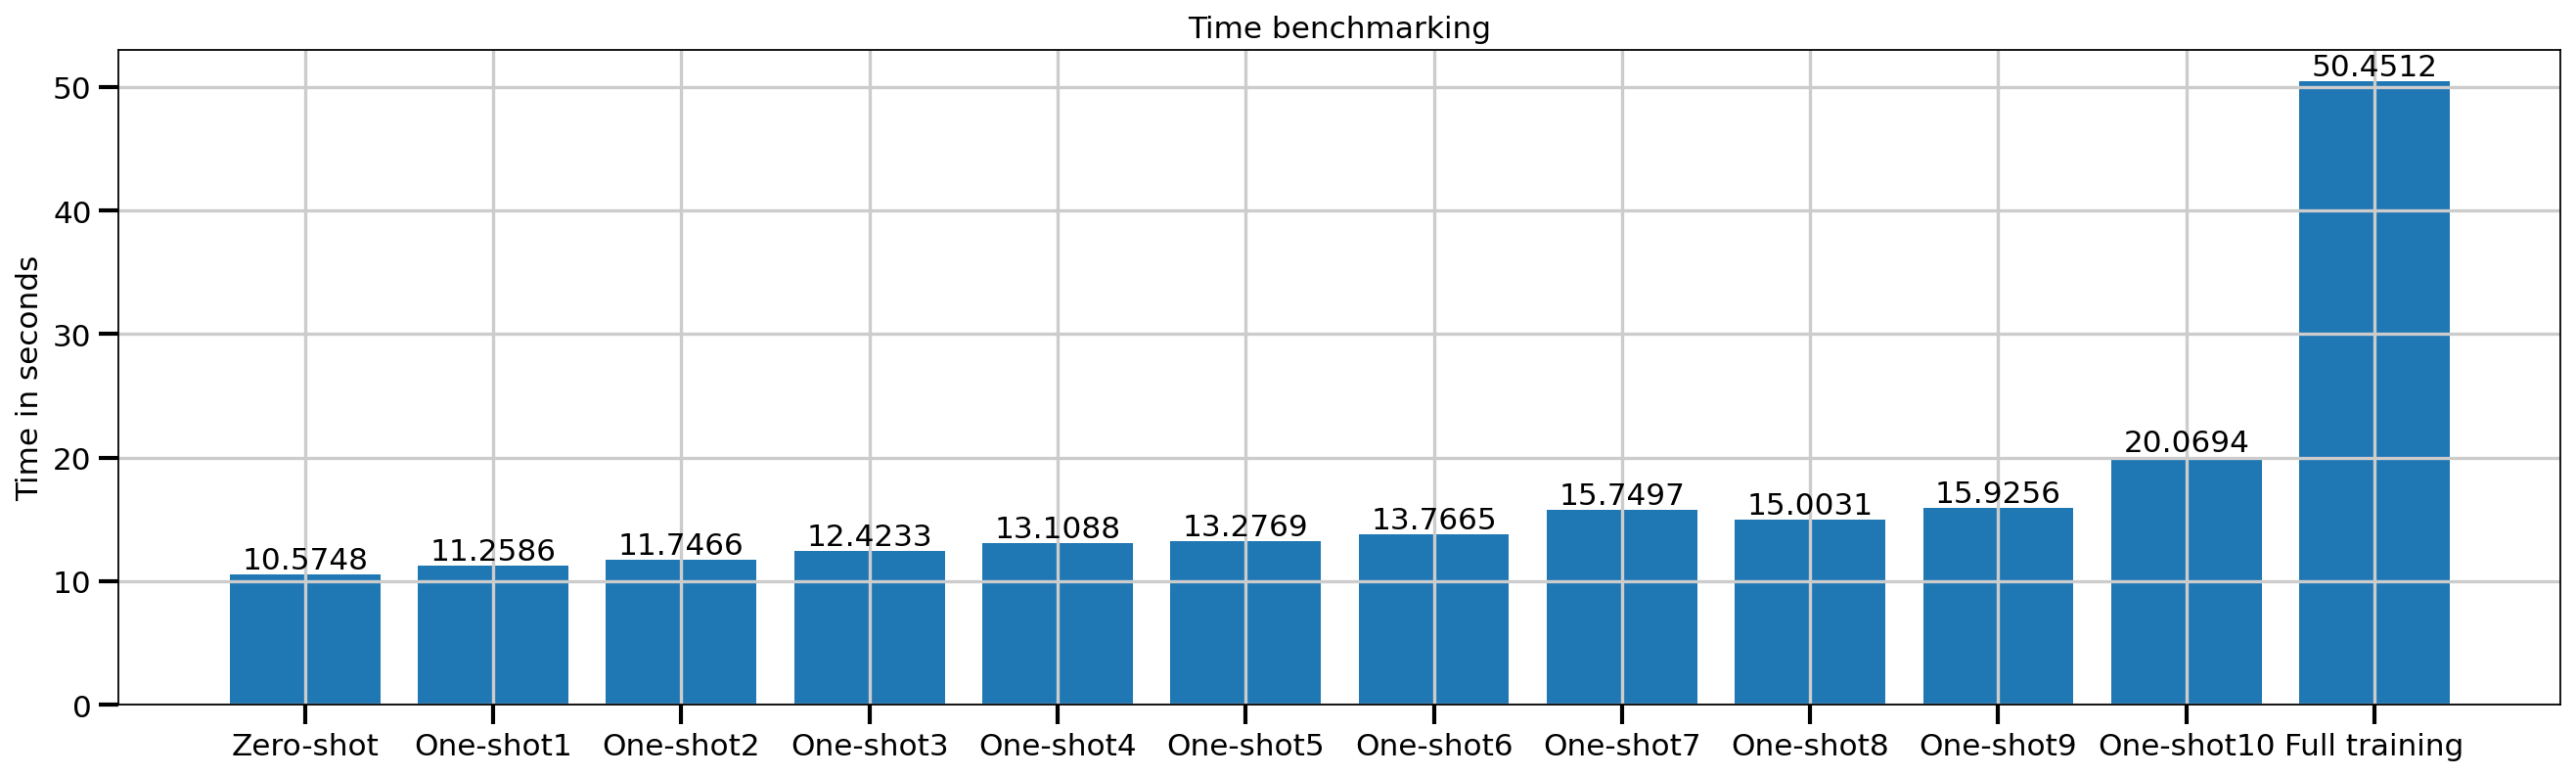

In [30]:
from matplotlib import pyplot as plt

time = time_one_array.copy()
time.reverse()
time.append(time_full)
time.insert(0, time_zero)

x = [f'One-shot{i}' for i in range(1,11)]
x.append('Full training')
x.insert(0, 'Zero-shot')

plt.rcParams["figure.figsize"] = (20,5.5)
bars = plt.bar(x, time)
plt.bar_label(bars)
plt.title('Time benchmarking')
plt.ylabel('Time in seconds')
plt.show()

#### Value loss comparison

In [31]:
val_loss_1 = query_model_one.trainer.logs["val_loss"]
val_loss_full = query_model_full.trainer.logs["val_loss"]

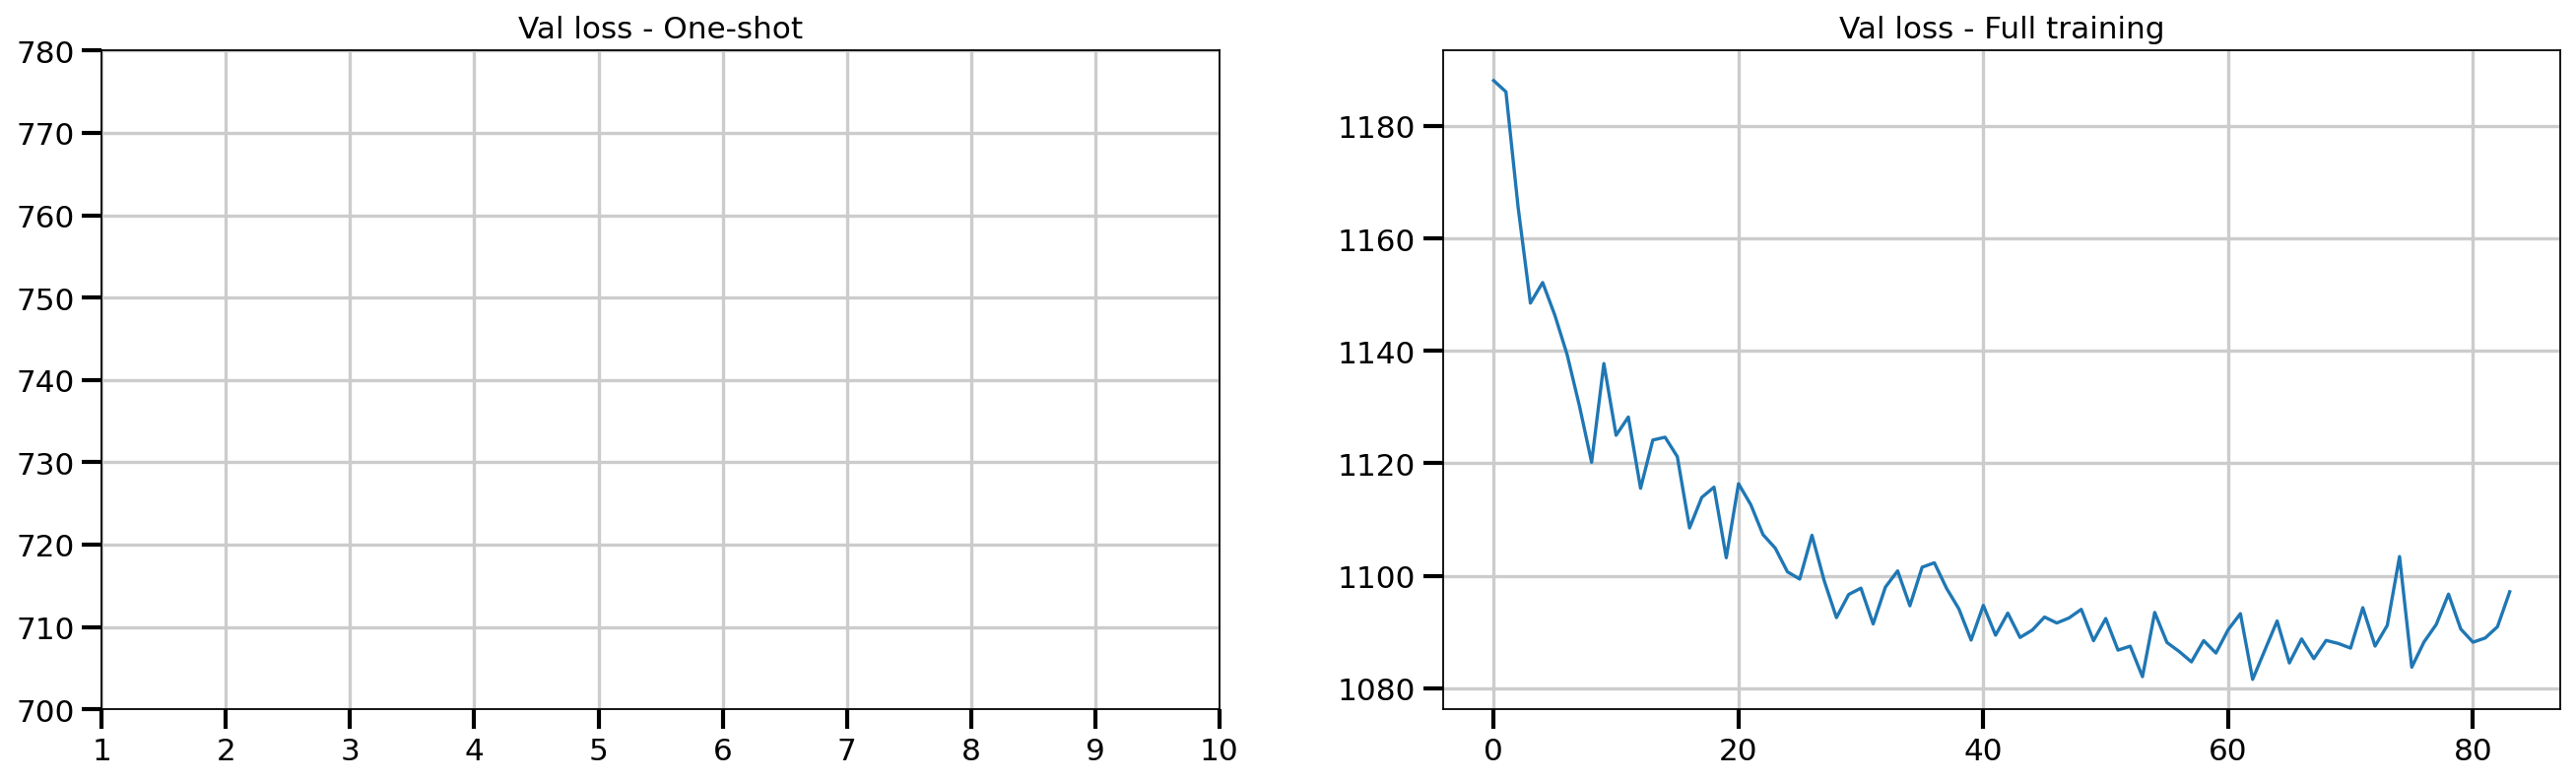

In [32]:

plt.subplot(1, 2, 1)
plt.plot(range(1,11), val_loss_1, label='Val loss')
plt.axis([1, 10, 700, 780])
plt.title('Val loss - One-shot')

plt.subplot(1, 2, 2)
plt.plot(range(len(val_loss_full)), val_loss_full, label='Val Loss')
plt.title('Val loss - Full training')
plt.show()

#### Latent Representations

In [33]:
surg_path = ['query_model_zero', 'query_model_one', 'query_model_full']

In [34]:
adata_latent_array = []
models = [query_model_zero, query_model_one, query_model_full]

In [35]:
for model in models:
    adata_latent = sc.AnnData(model.get_latent())
    adata_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
    adata_latent.obs['batch'] = target_adata.obs[condition_key].tolist()
    adata_latent_array.append(adata_latent)

In [36]:
adata_latent_array

[AnnData object with n_obs × n_vars = 10727 × 10
     obs: 'cell_type', 'batch',
 AnnData object with n_obs × n_vars = 10727 × 10
     obs: 'cell_type', 'batch',
 AnnData object with n_obs × n_vars = 10727 × 10
     obs: 'cell_type', 'batch']

In [37]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


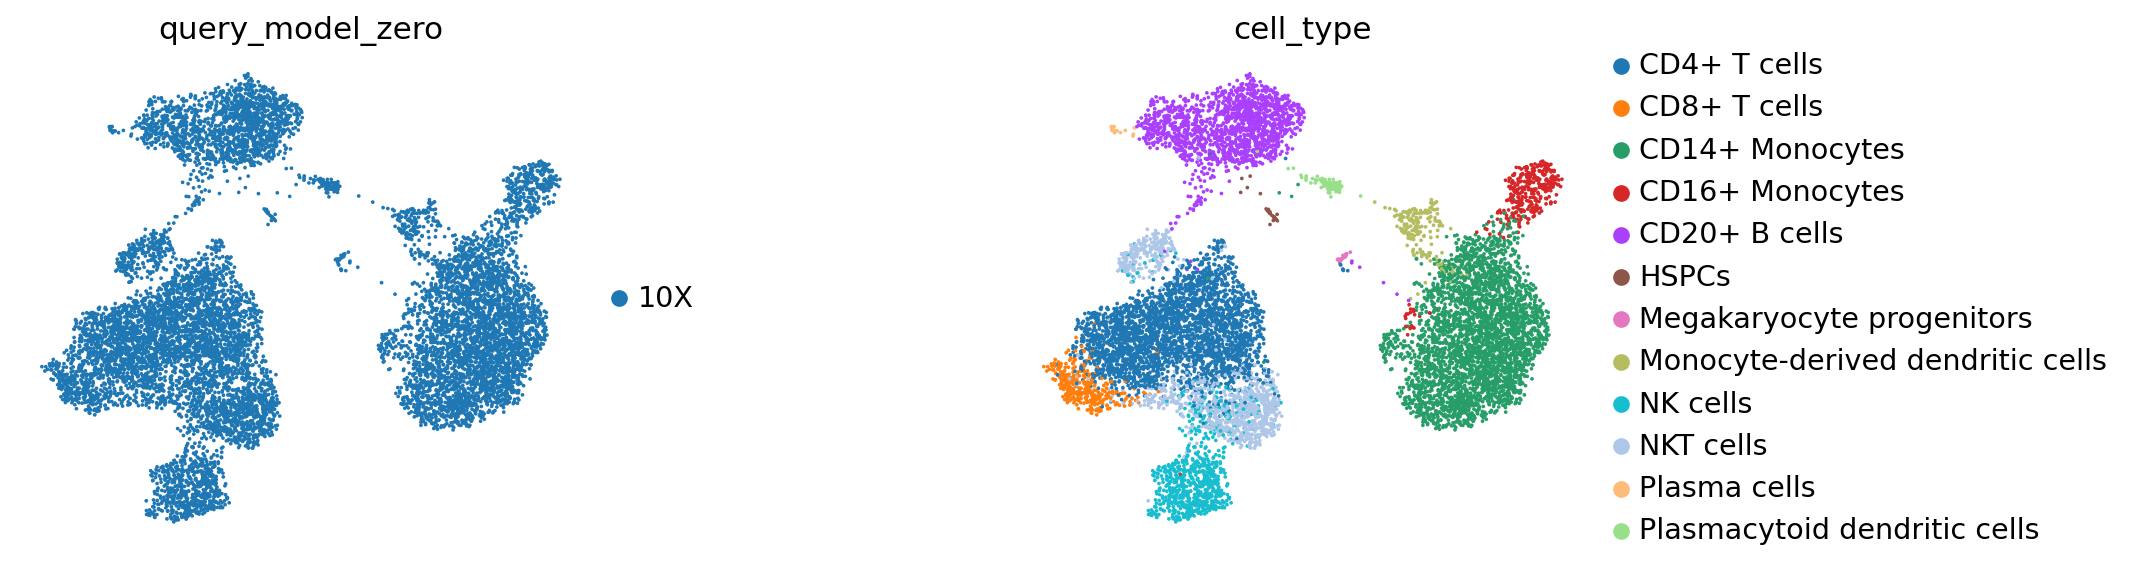

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


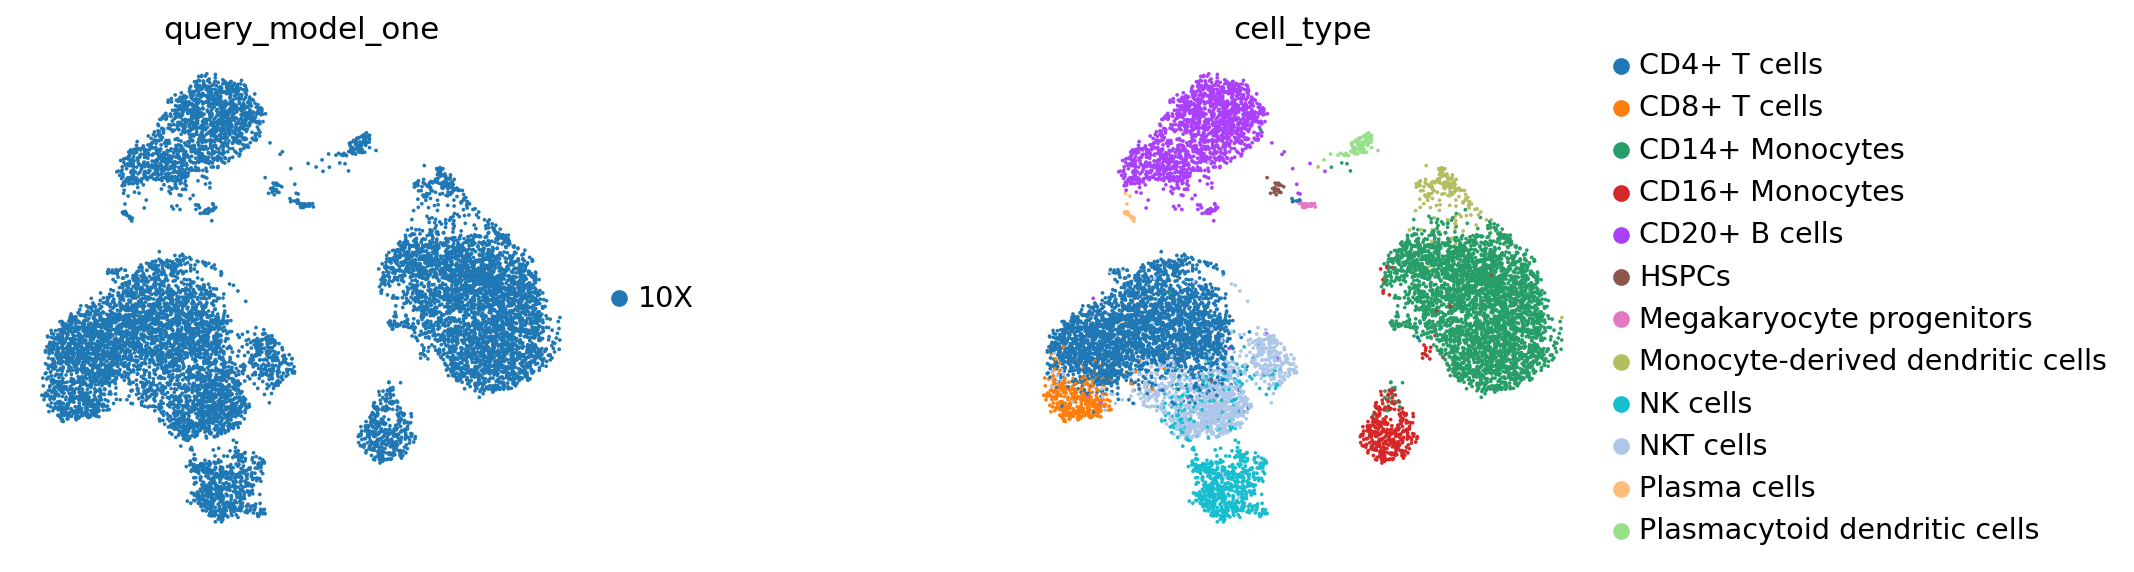

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


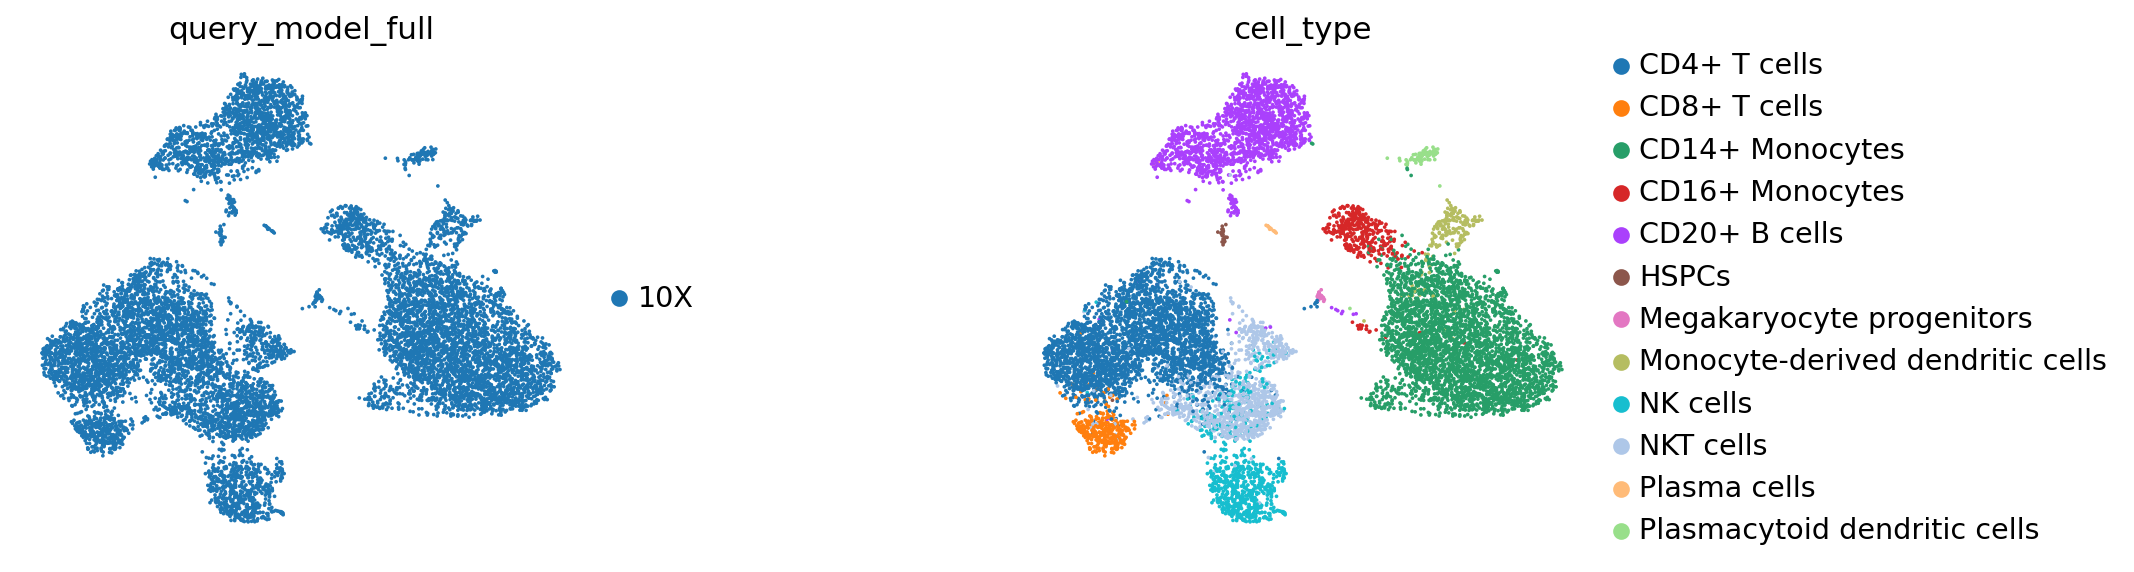

In [38]:
for i in range(len(adata_latent_array)):
    sc.pp.neighbors(adata_latent_array[i], n_neighbors=8)
    sc.tl.leiden(adata_latent_array[i])
    sc.tl.umap(adata_latent_array[i])
    sc.pl.umap(adata_latent_array[i],
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           title = surg_path[i]
           )

In [39]:
for j in range(len(models)):
    models[j].save(surg_path[j], overwrite=True)

### Get latent representation of reference + query dataset and compute UMAP

In [40]:
adata = adata[:, source_adata.var_names]
adata

View of AnnData object with n_obs × n_vars = 32484 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [41]:
full_latent_array = []

In [42]:
adata.obs['ref_or_query'] = np.where(adata.obs['batch'].isin(target_conditions), 'query', 'ref')

In [43]:
for model in models:
    full_latent = sc.AnnData(model.get_latent(adata.X, adata.obs[condition_key]))
    full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
    full_latent.obs['batch'] = adata.obs[condition_key].tolist()
    full_latent.obs['ref_or_query'] = adata.obs['ref_or_query'].tolist()
    full_latent_array.append(full_latent)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


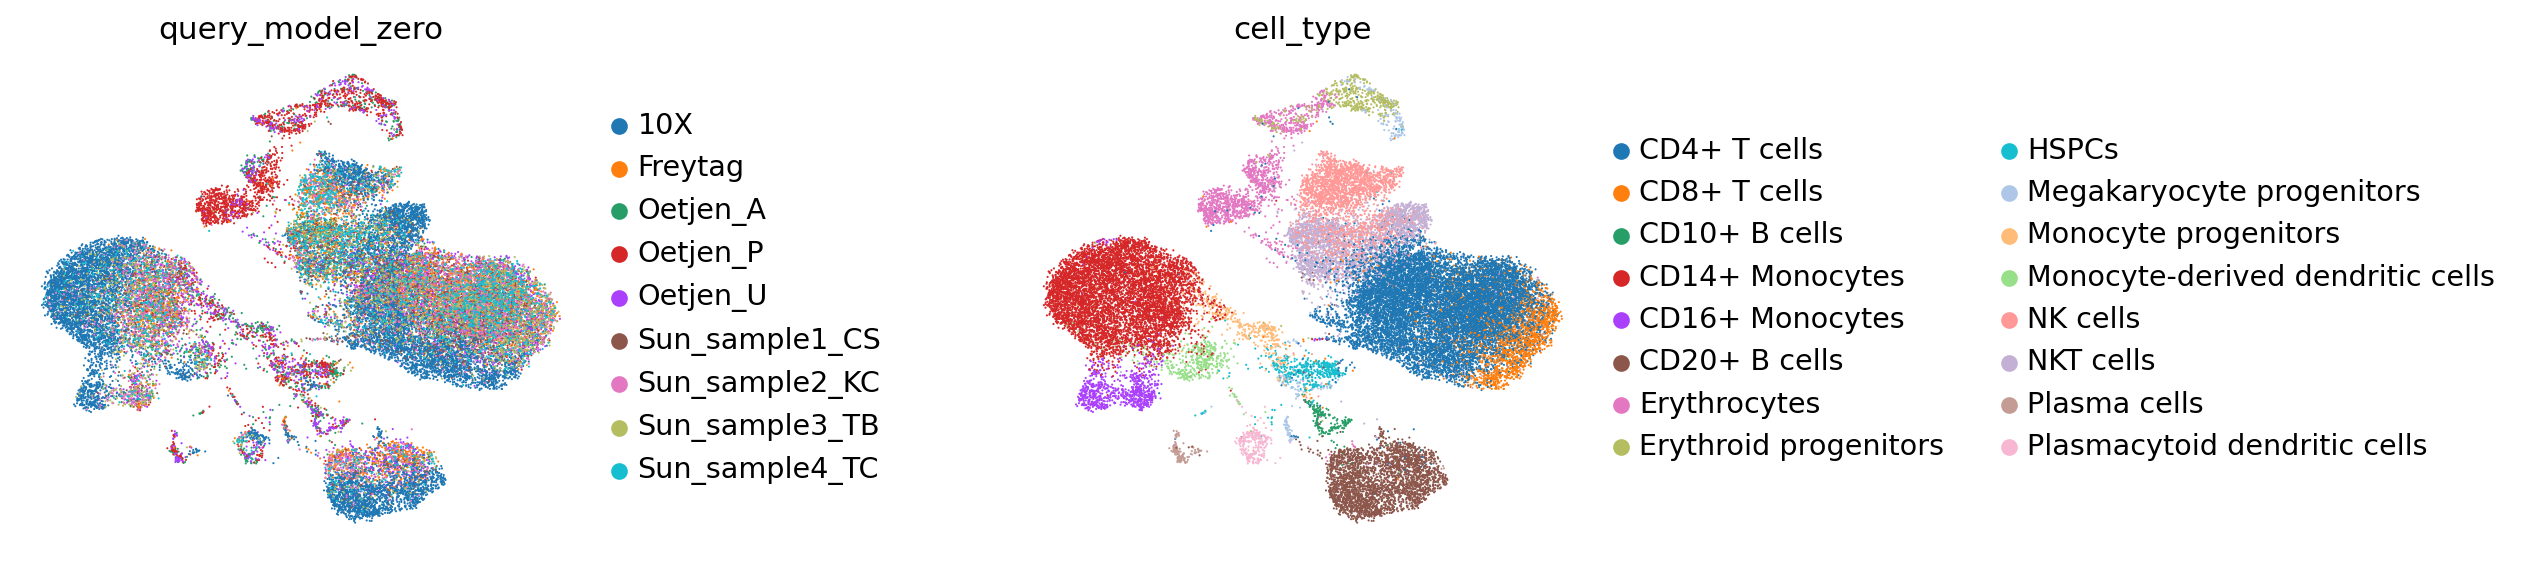

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


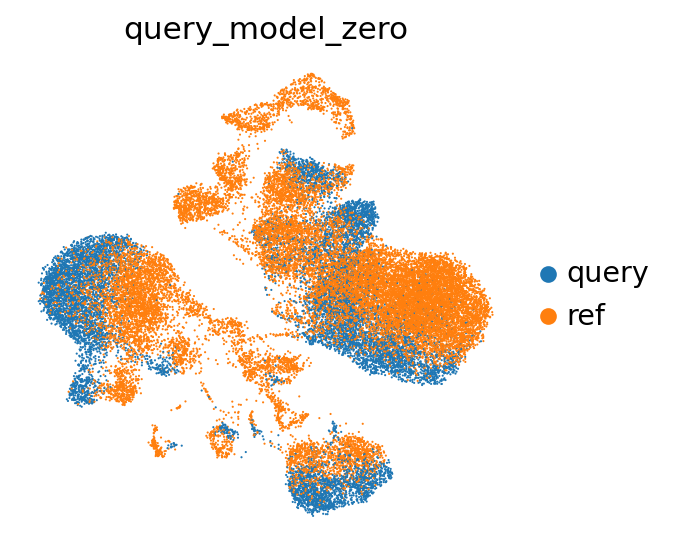

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


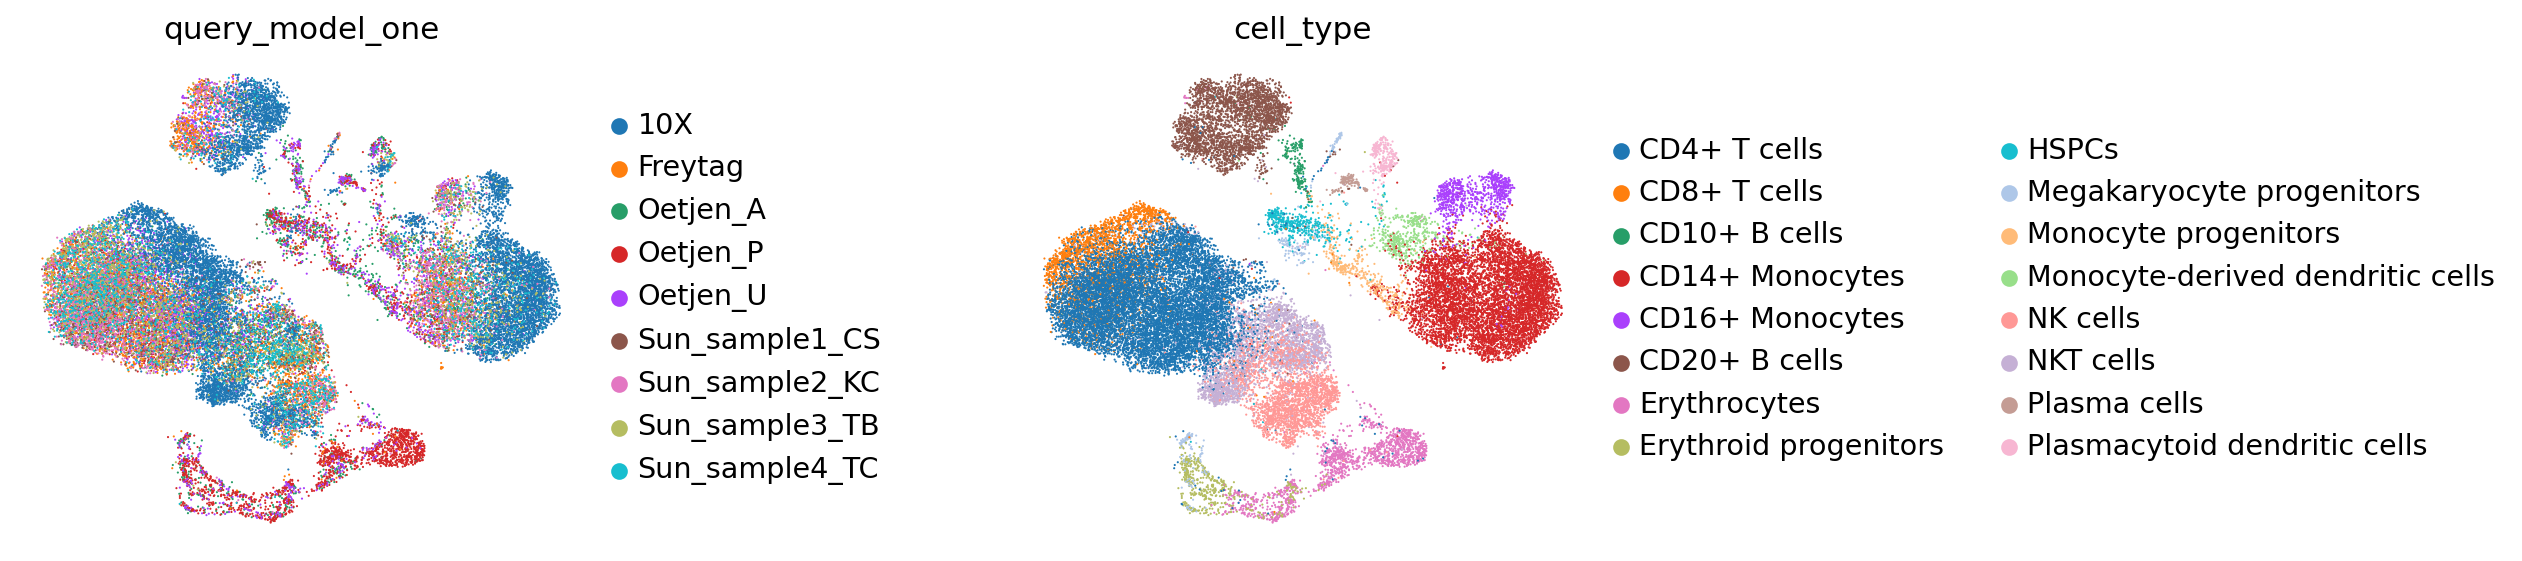

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


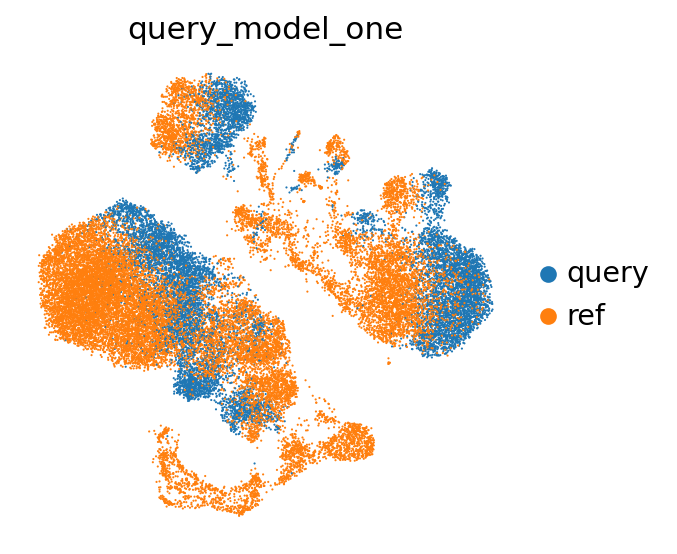

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


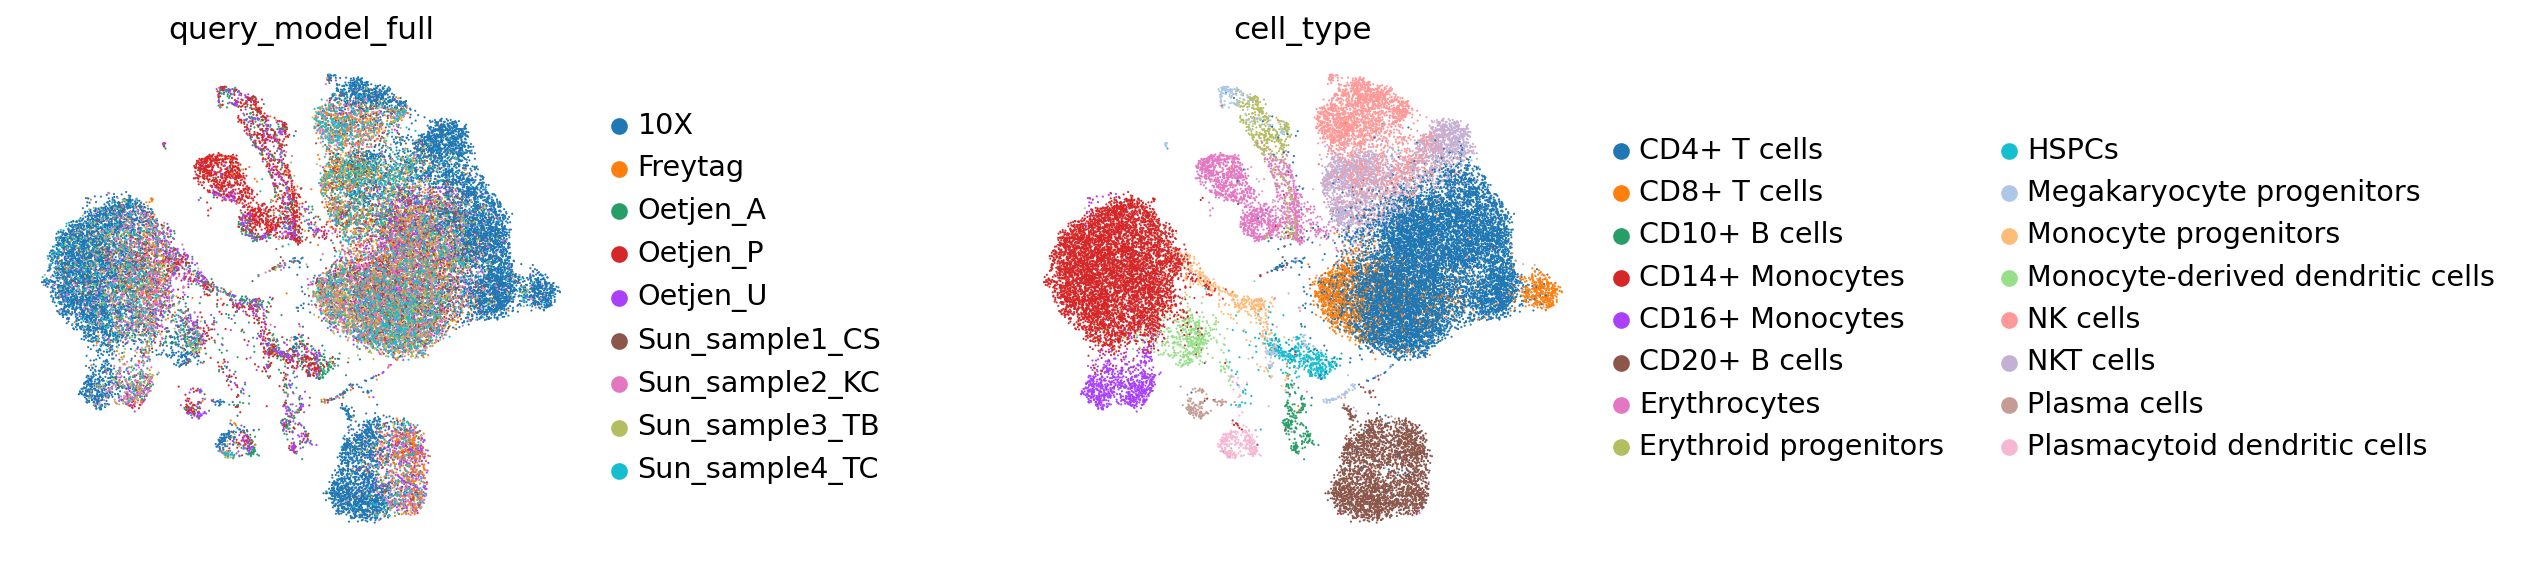

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


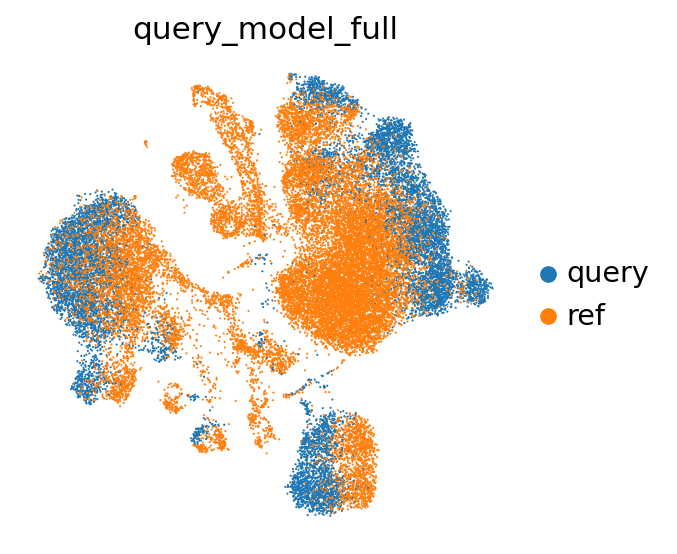

In [44]:
for i in range(len(full_latent_array)):
    sc.pp.neighbors(full_latent_array[i], n_neighbors=8)
    sc.tl.leiden(full_latent_array[i])
    sc.tl.umap(full_latent_array[i])
    sc.pl.umap(full_latent_array[i],
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           title = surg_path[i]
           )
    sc.pl.umap(full_latent_array[i],
           color=['ref_or_query'],
           frameon=False,
           wspace=0.6,
           title = surg_path[i]
           )

## Benchmarking for Biological Conservation and Batch Correction

In [45]:
results_array = []

In [46]:
full_latent_array

[AnnData object with n_obs × n_vars = 32484 × 10
     obs: 'cell_type', 'batch', 'ref_or_query', 'leiden'
     uns: 'neighbors', 'leiden', 'umap', 'batch_colors', 'cell_type_colors', 'ref_or_query_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 32484 × 10
     obs: 'cell_type', 'batch', 'ref_or_query', 'leiden'
     uns: 'neighbors', 'leiden', 'umap', 'batch_colors', 'cell_type_colors', 'ref_or_query_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 32484 × 10
     obs: 'cell_type', 'batch', 'ref_or_query', 'leiden'
     uns: 'neighbors', 'leiden', 'umap', 'batch_colors', 'cell_type_colors', 'ref_or_query_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities']

In [47]:
adata.obs['cell_type'] = adata.obs['final_annotation']

In [48]:
for i in range(len(full_latent_array)):
    results = scib.metrics.metrics(
        adata, full_latent_array[i],
        batch_key= 'batch',label_key = 'cell_type', organism= 'human', subsample=1., embed = 'X_umap',
        graph_conn_=True, nmi_ = True, ari_ = True,
        ilisi_=False, isolated_labels_asw_= True, cell_cycle_= True,
        silhouette_=True
    )
    results_array.append(results)

NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...
NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...
NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...


In [49]:
def median_bio_conserv(results):
    column = results[0]
    return (column.iloc[0] + column.iloc[1] + column.iloc[2] + column.iloc[4])/4

In [50]:
def median_batch_corr(results):
    column = results[0]
    return (column.iloc[3] + column.iloc[5] + column.iloc[6])/3

# Results

In [51]:
results_zero = results_array[0].dropna()


In [52]:
print('Zero shot: ')
print(f"bio_conservation = {median_bio_conserv(results=results_zero)}")
print(f"batch_correction = {median_batch_corr(results=results_zero)}")
results_zero

Zero shot: 
bio_conservation = 0.5801853177001772
batch_correction = 0.7483293042726135


0
NMI_cluster/label          0.756372
ARI_cluster/label          0.699694
ASW_label                  0.592402
ASW_label/batch            0.743834
cell_cycle_conservation    0.272272
isolated_label_silhouette  0.533941
graph_conn                 0.967213

In [53]:
results_one = results_array[1].dropna()

In [54]:
print('One shot: ')
print(f"bio_coservation = {median_bio_conserv(results=results_one)}")
print(f"batch_correction = {median_batch_corr(results=results_one)}")
results_one

One shot: 
bio_coservation = 0.5831825287844928
batch_correction = 0.7498739009569396


0
NMI_cluster/label          0.778218
ARI_cluster/label          0.731075
ASW_label                  0.590472
ASW_label/batch            0.749311
cell_cycle_conservation    0.232965
isolated_label_silhouette  0.538453
graph_conn                 0.961858

In [55]:
results_full = results_array[2].dropna()

In [56]:
print('Full query: ')
print(f"bio_conservation = {median_bio_conserv(results=results_full)}")
print(f"batch_correction = {median_batch_corr(results=results_full)}")
results_full

Full query: 
bio_conservation = 0.5839557543858219
batch_correction = 0.7318988812622084


0
NMI_cluster/label          0.750873
ARI_cluster/label          0.704871
ASW_label                  0.594480
ASW_label/batch            0.740397
cell_cycle_conservation    0.285600
isolated_label_silhouette  0.497857
graph_conn                 0.957443